In [1]:
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization
import os 
import pandas as pd
import plotly.graph_objs as go
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

2024-11-03 14:59:42.954825: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-03 14:59:43.090615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730638783.157042    6795 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730638783.178551    6795 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-03 14:59:43.320919: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import sys
print(sys.executable)


/home/peter/jupyter_env/bin/python3


In [3]:
# Step 1: Define the Dataset Path
# Specify the folder path where the dataset is stored for both training and testing sets.
dataset_folder = '/home/peter/Desktop/TU PHD/Project Apple-leaves-pathology/Apple_Data'

# Step 2: Load the CSV Files
# Load the training and testing datasets from the CSV files.
# train.csv contains the image IDs and associated labels (healthy, multiple_diseases, rust, scab).
# test.csv is used for generating predictions for evaluation.
train = pd.read_csv(os.path.join(dataset_folder, "train.csv"))
test = pd.read_csv(os.path.join(dataset_folder, "test.csv"))  # Load test data if available

# Step 3: Data Preprocessing - Update Image Filenames
# Append '.jpg' extension to the image IDs in both train and test datasets to match the actual filenames.
train['image_id'] = train['image_id'].apply(lambda x: x + '.jpg')
test['image_id'] = test['image_id'].apply(lambda x: x + '.jpg')  # Update for test set if applicable

# Step 4: Preview the Training Dataset
# Display the first few entries of the training DataFrame to confirm the data loading and processing.
print("Preview of the Training Dataset:")
display(train.head())  # Enhanced with display for better visualization in notebooks


Preview of the Training Dataset:


image_id  healthy  multiple_diseases  rust  scab
0  Train_0.jpg        0                  0     0     1
1  Train_1.jpg        0                  1     0     0
2  Train_2.jpg        1                  0     0     0
3  Train_3.jpg        0                  0     1     0
4  Train_4.jpg        1                  0     0     0

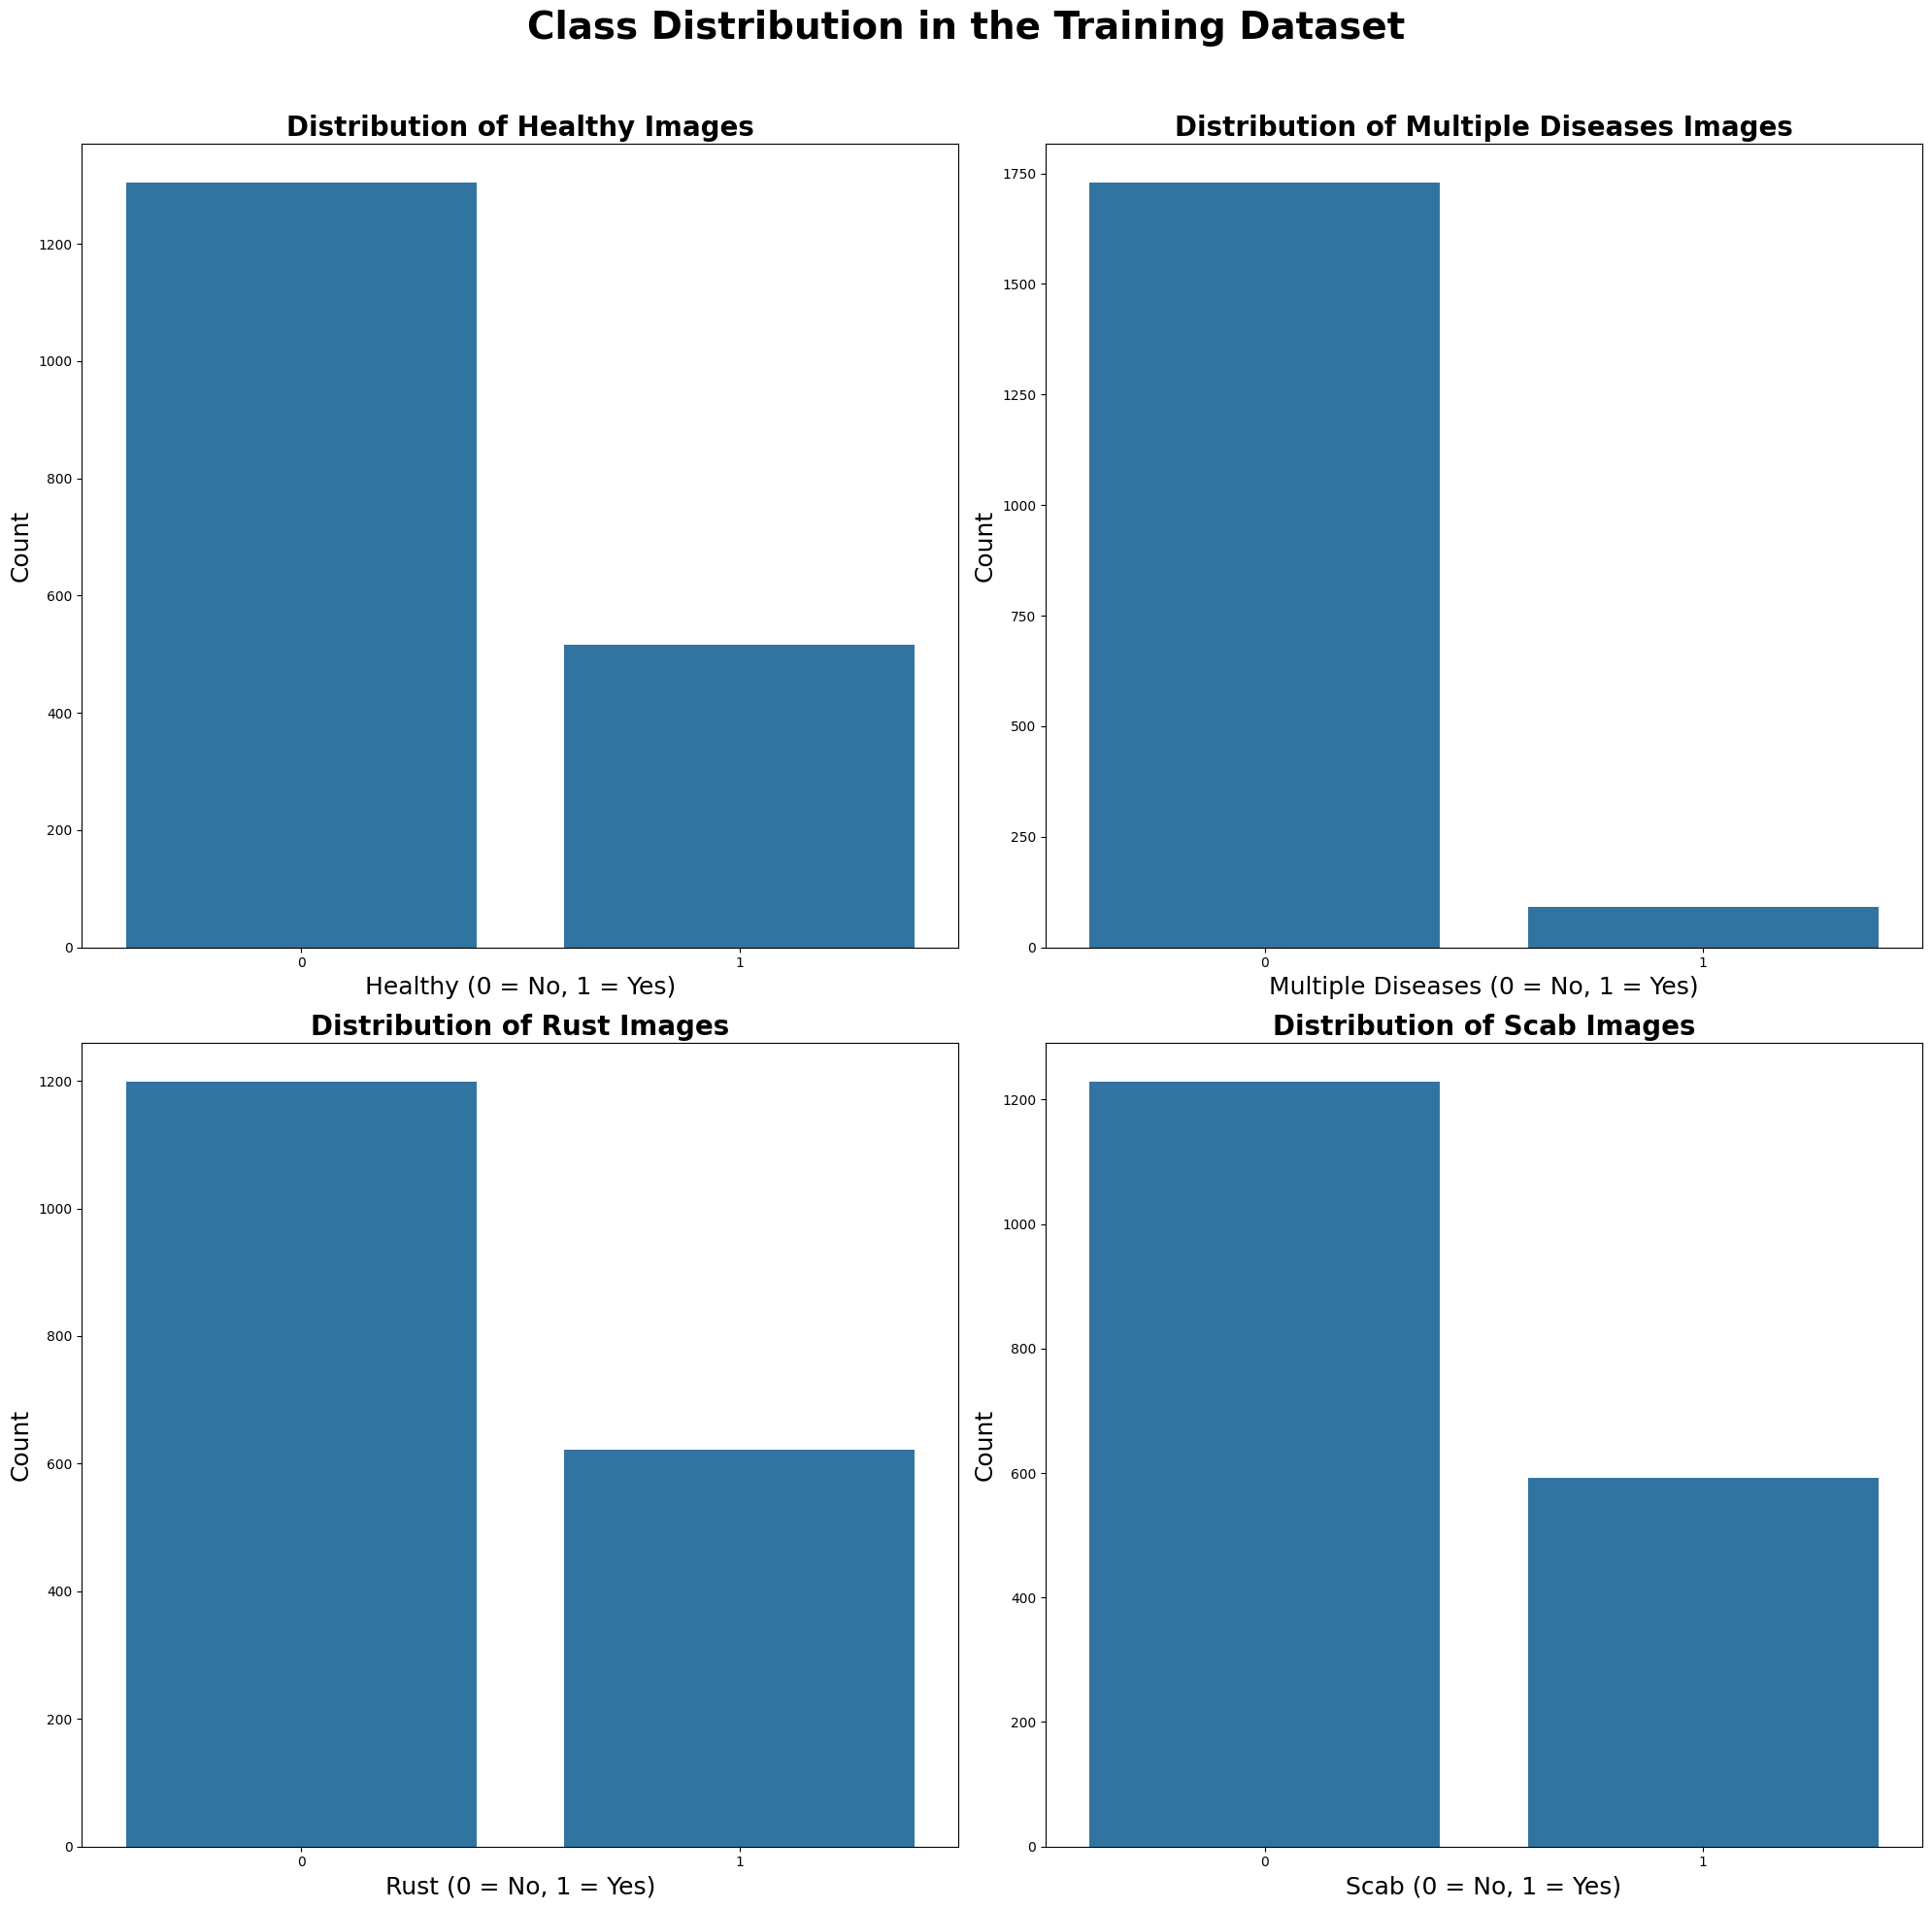

In [4]:
# Step 1: Visualize Class Distribution in the Training Dataset
# The training dataset consists of four classes: healthy, multiple_diseases, rust, and scab.
# We use bar plots to visualize the count of images in each class to understand the distribution and potential class imbalance.

fig, ax = plt.subplots(2, 2, figsize=(20, 20))  # Create a 2x2 grid of subplots for better layout

# Step 2: Plot the Distribution of "Healthy" Images
sns.barplot(y=train.healthy.value_counts(), x=train.healthy.value_counts().index, ax=ax[0, 0])
ax[0, 0].set_title("Distribution of Healthy Images", size=20, fontweight='bold')
ax[0, 0].set_xlabel('Healthy (0 = No, 1 = Yes)', size=18)
ax[0, 0].set_ylabel('Count', size=18)

# Step 3: Plot the Distribution of "Multiple Diseases" Images
sns.barplot(y=train.multiple_diseases.value_counts(), x=train.multiple_diseases.value_counts().index, ax=ax[0, 1])
ax[0, 1].set_title("Distribution of Multiple Diseases Images", size=20, fontweight='bold')
ax[0, 1].set_xlabel('Multiple Diseases (0 = No, 1 = Yes)', size=18)
ax[0, 1].set_ylabel('Count', size=18)

# Step 4: Plot the Distribution of "Rust" Images
sns.barplot(y=train.rust.value_counts(), x=train.rust.value_counts().index, ax=ax[1, 0])
ax[1, 0].set_title("Distribution of Rust Images", size=20, fontweight='bold')
ax[1, 0].set_xlabel('Rust (0 = No, 1 = Yes)', size=18)
ax[1, 0].set_ylabel('Count', size=18)

# Step 5: Plot the Distribution of "Scab" Images
sns.barplot(y=train.scab.value_counts(), x=train.scab.value_counts().index, ax=ax[1, 1])
ax[1, 1].set_title("Distribution of Scab Images", size=20, fontweight='bold')
ax[1, 1].set_xlabel('Scab (0 = No, 1 = Yes)', size=18)
ax[1, 1].set_ylabel('Count', size=18)

# Step 6: Final Adjustments for Better Visualization
plt.suptitle("Class Distribution in the Training Dataset", size=28, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to include the main title
plt.show()  # Display the plots


In [5]:
# Step 1: Image Data Preprocessing for Plant Pathology Classification
# Purpose: This cell reads and processes images from the dataset folder. Images are resized for consistent input dimensions 
# to the neural network and stored in a numpy array for efficient batch processing.

# Initialize an empty list to store the processed images
img = []

# Retrieve the list of image filenames from the 'train' DataFrame
filename = train['image_id']

# Step 2: Iterate through Each Image in the Training Set
# Each image is loaded, resized, and stored for further processing.
for file in filename:
    # Construct the complete path to each image file in the dataset directory
    image_path = os.path.join(dataset_folder, "images", file)
    
    # Read the image using OpenCV (cv2)
    image = cv2.imread(image_path)
    
    if image is not None:
        # Resize the image to (256, 256) pixels (height, width) for uniformity across the dataset
        res = cv2.resize(image, (256, 256))
        
        # Append the resized image to the list
        img.append(res)
    else:
        # Handle errors in image loading gracefully
        print(f"Error: Could not read image '{file}' from path '{image_path}'. Skipping this image.")

# Step 3: Convert the List of Images into a Numpy Array
# This format is suitable for feeding into a Convolutional Neural Network (CNN) model.
img = np.array(img)

# Display a message indicating the successful completion of image preprocessing
print(f"Total images successfully loaded and processed: {len(img)}")


Total images successfully loaded and processed: 1821


In [6]:
# Step 4: Inspect the Shape of the Processed Image Array
# Purpose: Checking the shape of the `img` array ensures that all images have been loaded correctly
# and verifies the dimensions before feeding them into the neural network for training.

# Print the shape of the numpy array containing the processed images
print(f"Shape of the processed image array: {img.shape}")

# Explanation of the Output:
# The shape should be in the format: (Total Images, Height, Width, Channels)
# For example, if we have 1821 images, each resized to 256x256 pixels, with 3 channels (RGB):
# Expected Output: (1821, 256, 256, 3)


Shape of the processed image array: (1821, 256, 256, 3)


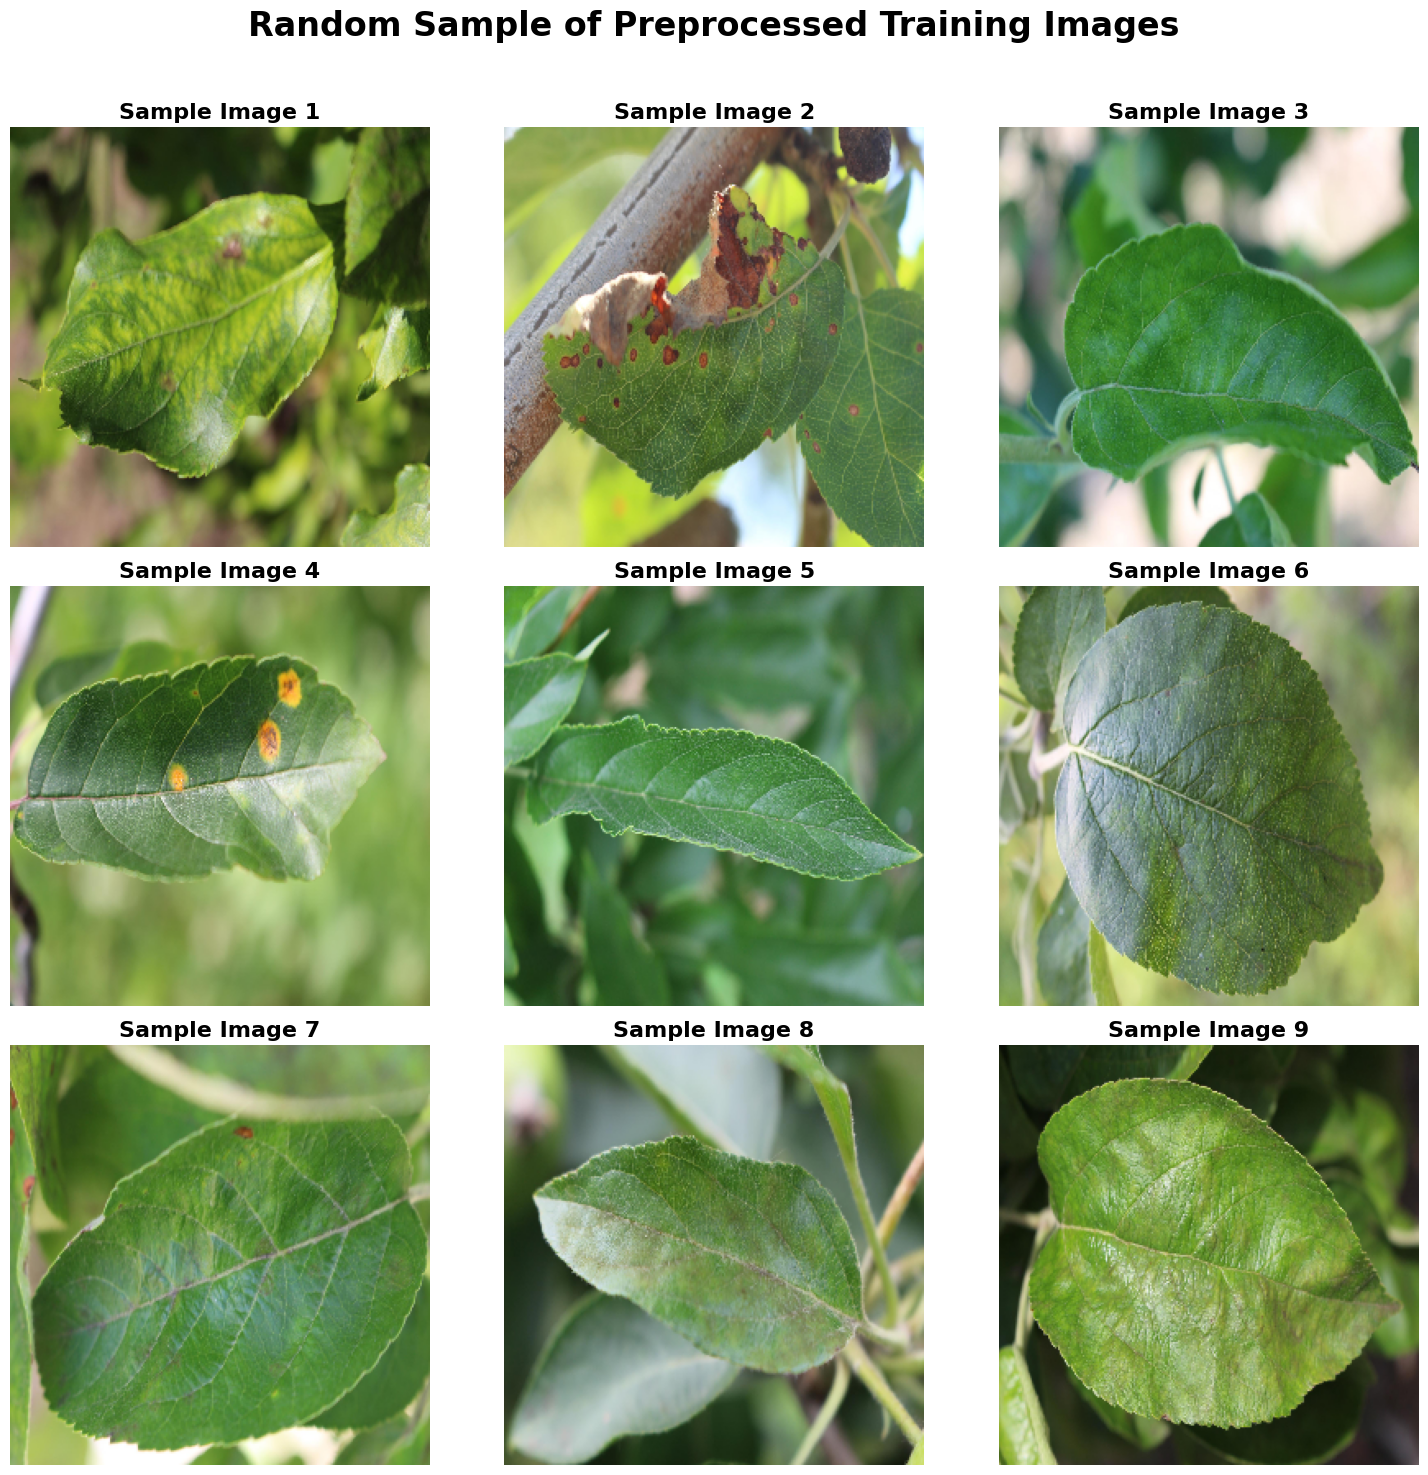

In [7]:
# Step 5: Visualize a Random Sample of Preprocessed Images from the Training Dataset
# Purpose: To confirm that the images have been correctly loaded, resized, and formatted.
# This visualization allows us to inspect the data visually and ensures that images are consistent in shape and quality.

plt.figure(figsize=(15, 15))  # Create a figure of size 15x15 for better visibility of multiple images

# Step 6: Display a 3x3 Grid of Sample Images
# Iterate through the first 9 images in the dataset and plot them in a 3x3 grid.
for i in range(9):
    plt.subplot(3, 3, i + 1)  # Define a 3x3 subplot grid and select the (i+1)-th position
    
    # Correct the color format from BGR to RGB for accurate display
    image_rgb = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)  
    
    # Display the image in the correct color format
    plt.imshow(image_rgb)
    
    # Add a title to each subplot indicating its index
    plt.title(f"Sample Image {i+1}", fontsize=16, fontweight='bold')
    plt.axis('off')  # Hide the axis for a cleaner look

# Step 7: Final Adjustments and Display
plt.suptitle("Random Sample of Preprocessed Training Images", size=24, fontweight='bold')  # Main title for the entire figure
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to avoid overlap
plt.show()  # Display the complete 3x3 grid of sample images


In [8]:
# Step 8: Prepare the Labels and Split the Dataset for Training and Validation
# Purpose: This step converts the target labels into a numerical format and performs a train-validation split.
# The goal is to create separate subsets for training and validation to ensure robust model evaluation.

# Convert the class labels from the 'train' DataFrame into a format compatible with model training.
# This extracts the columns from 'healthy' to 'scab' (inclusive) and converts them to a float32 numpy array.
train_labels = np.float32(train.loc[:, 'healthy':'scab'].values)

# Step 9: Perform Train-Validation Split
# Split the data into training and validation sets using a 85%:15% ratio.
# The validation set is used for evaluating the model's performance during training.
train, val = train_test_split(train, test_size=0.15, random_state=42, stratify=train_labels)

# Display the shape of the split datasets for confirmation
print(f"Training Set Size: {train.shape[0]} samples")
print(f"Validation Set Size: {val.shape[0]} samples")

# Explanation:
# - `random_state=42` ensures reproducibility of the split.
# - `stratify=train_labels` ensures that class distribution is maintained between the training and validation sets.
# - This step is crucial for preventing overfitting and ensuring the model generalizes well to unseen data.


Training Set Size: 1547 samples
Validation Set Size: 274 samples


In [9]:
# Step 10: Image Data Augmentation for Training the Model
# Purpose: Image data augmentation is used to artificially increase the diversity of the training set.
# This step helps the model generalize better by learning from a wider variety of transformations, 
# which is crucial for reducing overfitting.

from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Initialize the ImageDataGenerator with a variety of augmentations
train_datagen = ImageDataGenerator(
    horizontal_flip=True,      # Randomly flip inputs horizontally (simulates leaf orientation variations)
    vertical_flip=True,        # Randomly flip inputs vertically (adds variety in up-down variations)
    rotation_range=10,         # Randomly rotate images in the range of 0-10 degrees (handles slight leaf rotation)
    width_shift_range=0.1,     # Shift images horizontally by 10% of the total width (adds robustness to position variance)
    height_shift_range=0.1,    # Shift images vertically by 10% of the total height (models leaf position changes)
    zoom_range=0.1,            # Randomly zoom in/out on images by 10% (learns scale variance)
    shear_range=0.1,           # Shear the images by 10% (applies affine transformations, useful for shape variations)
    fill_mode='nearest',       # Fill missing pixels after transformations using the nearest value
    rescale=1/255,             # Rescale pixel values from [0, 255] to [0, 1] for normalization
    brightness_range=[0.5, 1.5]  # Randomly adjust the brightness of images (handles lighting variations)
)

# Explanation of Each Parameter:
# 1. **horizontal_flip**: Useful for augmenting symmetrical data.
# 2. **vertical_flip**: Adds vertical symmetry, especially for leaves in different orientations.
# 3. **rotation_range**: Prevents overfitting to specific rotations, making the model robust to angle changes.
# 4. **width_shift_range** and **height_shift_range**: Simulates changes in leaf position within the frame.
# 5. **zoom_range**: Helps the model learn features at different scales.
# 6. **shear_range**: Applies affine transformations, mimicking perspective changes.
# 7. **fill_mode='nearest'**: Maintains pixel integrity during transformations, filling gaps using neighboring pixels.
# 8. **rescale=1/255**: Normalizes the image data for faster convergence during training.
# 9. **brightness_range**: Adds robustness to varying lighting conditions in real-world scenarios.

# Why This Matters:
# Data augmentation helps create a more diverse training set by applying transformations that mimic real-world variations.
# This is especially crucial for leaf pathology detection, where environmental factors (lighting, orientation) can vary significantly.


In [10]:
# Step 11: Create the Training Data Generator
# Purpose: The `flow_from_dataframe()` method is used to load image data and labels directly from the DataFrame.
# This function reads images from the specified directory based on file paths listed in the DataFrame,
# applies real-time data augmentation, and outputs batches of images and their corresponding labels.

# Initialize the training data generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,  # The DataFrame containing the file paths and labels for training data
    directory=os.path.join(dataset_folder, "images"),  # Directory containing the image files
    x_col="image_id",  # Column name in the DataFrame that contains the filenames of images
    y_col=['healthy', 'multiple_diseases', 'rust', 'scab'],  # Columns that define the target labels
    target_size=(384, 384),  # Resize all images to the specified target size (384x384 pixels) for consistency
    class_mode='raw',  # Use 'raw' to directly output multi-label targets without one-hot encoding
    batch_size=32,     # Number of images to generate per batch (determined based on GPU capacity)
    shuffle=True,      # Shuffle the order of images to ensure randomness during training
    seed=42            # Seed for reproducibility to maintain the same shuffled order across runs
)

# Explanation of Each Parameter:
# 1. **dataframe=train**: Specifies the DataFrame that contains file paths and labels for the training data.
# 2. **directory=os.path.join(dataset_folder, "images")**: Defines the path to the directory containing the images.
# 3. **x_col="image_id"**: Identifies the column that has the image filenames, mapping each row to an image.
# 4. **y_col=['healthy', 'multiple_diseases', 'rust', 'scab']**: Specifies the columns corresponding to the multi-label targets.
# 5. **target_size=(384, 384)**: All images are resized to 384x384 pixels to standardize input dimensions.
# 6. **class_mode='raw'**: Outputs labels as they are, which is suitable for multi-label classification problems.
# 7. **batch_size=32**: Controls the number of images per batch. Adjust this based on your GPU memory capacity.
# 8. **shuffle=True**: Ensures the images are randomly shuffled, reducing the risk of model overfitting.
# 9. **seed=42**: Sets a seed value for reproducibility of the shuffling process.

# Why This Matters:
# Using `flow_from_dataframe()` is ideal for handling large datasets that cannot be fully loaded into memory.
# It allows for real-time data augmentation and efficient data pipeline creation, ensuring that the training process
# can handle dynamically loaded data without performance degradation.

# Display a summary of the generator
print(f"Total number of images loaded for training: {train_generator.n}")
print(f"Batch size: {train_generator.batch_size}")
print(f"Image shape: {train_generator.image_shape}")


Found 1547 validated image filenames.
Total number of images loaded for training: 1547
Batch size: 32
Image shape: (384, 384, 3)


In [11]:
# Step 12: Create the Validation Data Generator
# Purpose: The `val_generator` is used to generate batches of images and labels from the validation set. 
# This ensures that the model is evaluated on unseen data during training, providing a reliable estimate 
# of how well the model generalizes beyond the training data.

# Initialize the validation data generator using the same data augmentation pipeline (`train_datagen`)
val_generator = train_datagen.flow_from_dataframe(
    dataframe=val,  # The DataFrame containing the file paths and labels for validation data
    directory=os.path.join(dataset_folder, "images"),  # Directory where the image files are stored
    x_col="image_id",  # Column in the DataFrame that has the image filenames
    y_col=['healthy', 'multiple_diseases', 'rust', 'scab'],  # Columns representing multi-label targets
    target_size=(384, 384),  # Resize all images to the specified target size (384x384 pixels)
    class_mode='raw',  # Use 'raw' to directly output multi-label targets as arrays without one-hot encoding
    batch_size=32,     # Number of images to generate per batch
    shuffle=False,     # Do not shuffle the validation data to ensure consistent evaluation across epochs
    seed=42            # Seed for reproducibility of the image loading order
)

# Explanation of Each Parameter:
# 1. **dataframe=val**: Specifies the DataFrame that contains file paths and labels for the validation data.
# 2. **directory=os.path.join(dataset_folder, "images")**: Defines the path to the directory containing the images.
# 3. **x_col="image_id"**: Identifies the column that has the image filenames, mapping each row to an image.
# 4. **y_col=['healthy', 'multiple_diseases', 'rust', 'scab']**: Specifies the columns corresponding to the multi-label targets.
# 5. **target_size=(384, 384)**: All images are resized to 384x384 pixels to match the dimensions of the training set.
# 6. **class_mode='raw'**: Outputs labels as they are, suitable for multi-label classification problems.
# 7. **batch_size=32**: Controls the number of images per batch.
# 8. **shuffle=False**: Validation data should not be shuffled to ensure that the evaluation order is consistent across epochs.
# 9. **seed=42**: Sets a seed value for reproducibility of the loading order.

# Why This Matters:
# Consistent evaluation is critical during training to track model performance. By not shuffling the validation set, 
# we ensure that the same images are used for validation in the same order, reducing variance in the evaluation metrics.

# Display a summary of the validation generator for confirmation
print(f"Total number of images loaded for validation: {val_generator.n}")
print(f"Batch size: {val_generator.batch_size}")
print(f"Image shape: {val_generator.image_shape}")


Found 274 validated image filenames.
Total number of images loaded for validation: 274
Batch size: 32
Image shape: (384, 384, 3)


In [12]:
# Step 13: Create the Test Data Generator
# Purpose: The `test_generator` is used to generate batches of images from the test set without labels.
# This allows us to perform inference and generate predictions for the test set without affecting the model's training.
# It’s designed for evaluating the model on unseen data and preparing the final output for submission.

# Initialize the test data generator
test_generator = train_datagen.flow_from_dataframe(
    dataframe=test,  # The DataFrame containing the file paths for the test images
    directory=os.path.join(dataset_folder, "images"),  # Directory containing the image files
    x_col="image_id",  # Column in the DataFrame that has the image filenames
    y_col=None,  # Test data has no labels; set to None
    target_size=(384, 384),  # Resize all images to the specified target size (384x384 pixels)
    class_mode=None,  # Since we do not have labels for the test set, we set class_mode to None
    batch_size=32,     # Number of images to generate per batch
    shuffle=False,     # Do not shuffle the test data to maintain the order for consistent results
    seed=42            # Seed for reproducibility of the loading order
)

# Explanation of Each Parameter:
# 1. **dataframe=test**: Specifies the DataFrame that contains file paths for the test images.
# 2. **directory=os.path.join(dataset_folder, "images")**: Defines the path to the directory containing the images.
# 3. **x_col="image_id"**: Identifies the column that has the image filenames, mapping each row to an image.
# 4. **y_col=None**: Since the test data does not have labels, we set `y_col` to `None`.
# 5. **target_size=(384, 384)**: All images are resized to 384x384 pixels to match the training and validation dimensions.
# 6. **class_mode=None**: The `class_mode` is set to `None` because no labels are used, and we only want to perform inference.
# 7. **batch_size=32**: Controls the number of images per batch.
# 8. **shuffle=False**: Test data should not be shuffled to maintain the original order, ensuring that predictions are mapped correctly.
# 9. **seed=42**: Sets a seed value for reproducibility of the image loading order.

# Why This Matters:
# This setup is crucial for generating predictions on the test data in a structured manner.
# Setting `class_mode=None` is especially important when labels are not available, as it ensures that the generator
# only outputs images without attempting to pair them with non-existent labels.

# Display a summary of the test generator for confirmation
print(f"Total number of images loaded for testing: {test_generator.n}")
print(f"Batch size: {test_generator.batch_size}")
print(f"Image shape: {test_generator.image_shape}")


Found 1821 validated image filenames.
Total number of images loaded for testing: 1821
Batch size: 32
Image shape: (384, 384, 3)


In [13]:
# Step 14: Define and Compile the Fine-Tuned ResNet50 Model
# Purpose: In this step, we leverage transfer learning by using a pre-trained ResNet50 model as the backbone.
# We customize it by adding fully connected layers at the top to adapt it for the multi-class leaf pathology classification.
# This approach allows us to benefit from a powerful, pre-trained network, while making it specific to our problem.

from keras.applications.resnet50 import ResNet50  # Import ResNet50 for transfer learning
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense  # Layers used for building the model architecture
from keras import optimizers  # Optimizers for model training

# Step 15: Load the Pre-trained ResNet50 Model (Without Top Layers)
# We set `include_top=False` to exclude the fully connected layers of the original ResNet50,
# allowing us to customize the model for our specific task.
model_finetuned = ResNet50(
    include_top=False,          # Exclude the top fully connected layers
    weights='imagenet',         # Use weights pre-trained on ImageNet
    input_shape=(384, 384, 3)   # Define the input shape for our images (384x384 RGB)
)

# Step 16: Add Custom Layers for Multi-Class Classification
# Add a global average pooling layer to reduce the dimensionality of the ResNet output.
x = model_finetuned.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling instead of Flattening (prevents overfitting)

# Add two fully connected layers with ReLU activations for non-linearity.
x = Dense(128, activation="relu")(x)  # First dense layer with 128 neurons
x = Dense(64, activation="relu")(x)   # Second dense layer with 64 neurons

# Add the output layer with 4 neurons (one for each class) and a softmax activation function.
# This layer outputs the probability distribution over the 4 classes: healthy, multiple diseases, rust, scab.
predictions = Dense(4, activation="softmax")(x)

# Step 17: Compile the Model for Training
# Create the final model by connecting the ResNet50 base and the custom top layers.
model_finetuned = Model(inputs=model_finetuned.input, outputs=predictions)

# Compile the model using the Adam optimizer and categorical cross-entropy loss.
# We use 'accuracy' as the evaluation metric since we are dealing with a multi-class problem.
model_finetuned.compile(
    optimizer='adam',                  # Adam optimizer for efficient gradient updates
    loss='categorical_crossentropy',   # Use categorical cross-entropy for multi-class classification
    metrics=['accuracy']               # Track accuracy during training and evaluation
)

# Display the model architecture
print("Summary of the Fine-Tuned ResNet50 Model:\n")
model_finetuned.summary()  # Display the model architecture


2024-11-03 14:59:59.264585: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Summary of the Fine-Tuned ResNet50 Model:



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 384, 384,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 390, 390,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 192, 192,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 192, 192,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 192, 192,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 194, 194,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 96, 96,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 96, 96,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 96, 96,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 96, 96,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 96, 96,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 96, 96,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 96, 96,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 96, 96,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 96, 96,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 96, 96,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 96, 96,    │      1,024 │ conv2_block1_3_c

 Total params: 23,858,500 (91.01 MB)

 Trainable params: 23,805,380 (90.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [14]:
# Step 18: Import ReduceLROnPlateau Callback for Dynamic Learning Rate Adjustment
# Purpose: The `ReduceLROnPlateau` callback is used to adjust the learning rate when the model stops improving.
# This helps prevent the model from stagnating and ensures faster convergence.
# When the validation loss stops decreasing, the learning rate is reduced by a factor, allowing the model to fine-tune itself.

from keras.callbacks import ReduceLROnPlateau

# Explanation of `ReduceLROnPlateau`:
# - The learning rate is one of the most important hyperparameters in training neural networks.
# - If the learning rate is too high, the model may converge too quickly to a suboptimal solution.
# - If the learning rate is too low, training may become slow and the model might get stuck in local minima.
# - `ReduceLROnPlateau` dynamically adjusts the learning rate during training based on the monitored metric, making it more adaptable.

# Why Use `ReduceLROnPlateau`?
# During training, if the validation loss does not improve for a specified number of epochs, 
# this callback reduces the learning rate by a certain factor. This encourages the model to explore smaller updates,
# which can help it find a better local minimum and improve overall performance.

# Step 19: Define the Callback for Training
# We monitor the 'val_loss' and reduce the learning rate by a factor of 0.3 if the loss does not improve for 3 consecutive epochs.
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # The metric to be monitored
    factor=0.3,              # Factor by which the learning rate will be reduced
    patience=3,              # Number of epochs with no improvement after which the learning rate will be reduced
    min_lr=1e-6,             # Minimum learning rate limit to avoid very small values
    verbose=1                # Print updates regarding the learning rate changes
)

# Explanation of Each Parameter:
# 1. **monitor='val_loss'**: The validation loss is monitored to determine when the learning rate should be reduced.
# 2. **factor=0.3**: Each time the learning rate is reduced, it is multiplied by 0.3.
# 3. **patience=3**: If the validation loss does not improve for 3 epochs, the learning rate is reduced.
# 4. **min_lr=1e-6**: Sets a lower limit for the learning rate to prevent it from becoming too small.
# 5. **verbose=1**: Prints a message each time the learning rate is reduced, providing transparency during training.

# Why This Matters:
# Using `ReduceLROnPlateau` is crucial for optimizing training in deep learning models.
# It allows the model to dynamically adjust its learning rate based on feedback from the validation loss, preventing overshooting or stagnation.


In [15]:
# Step 20: Model Training with the Fine-Tuned ResNet50 Architecture
# Purpose: This step involves training the fine-tuned ResNet50 model using the defined training and validation generators.
# The goal is to optimize the model weights by minimizing the categorical cross-entropy loss while tracking accuracy.
# A learning rate scheduler (ReduceLROnPlateau) is employed to dynamically adjust the learning rate based on the validation loss.

from tensorflow.keras.callbacks import ReduceLROnPlateau

# Step 21: Adjust the Batch Size to Prevent GPU Memory Overflow
# Reason: A lower batch size is often used when working with large models or high-resolution images to prevent memory issues.
train_generator.batch_size = 8  # Set batch size to 8 for training
val_generator.batch_size = 8    # Set batch size to 8 for validation

# Step 22: Calculate Steps per Epoch for Training and Validation
# Formula: `steps_per_epoch` is calculated as the total number of samples divided by the batch size.
# This determines how many batches of data will be used in one epoch.
train_steps = train_generator.n // train_generator.batch_size
val_steps = val_generator.n // val_generator.batch_size

print(f"Training Steps per Epoch: {train_steps}")
print(f"Validation Steps per Epoch: {val_steps}")

# Step 23: Train the Model with Configured Parameters
# Use the `.fit()` function to train the model using the training data generator.
# Step 23: Train the Model with Configured Parameters
history_1 = model_finetuned.fit(
    train_generator,               # Training data generator that yields batches of augmented images and labels
    steps_per_epoch=train_steps,   # Number of batches to draw from the generator during each epoch
    epochs=25,                     # Total number of iterations over the entire training dataset
    validation_data=val_generator, # Validation data generator for evaluating model performance
    validation_steps=val_steps,    # Number of validation batches to draw during each epoch
    verbose=1,                     # Display progress bar (1 = show progress bar, 0 = silent, 2 = one line per epoch)
    callbacks=[ReduceLROnPlateau(  # List of callbacks to apply during training
        monitor='val_loss',        # Monitor validation loss to detect plateaus
        factor=0.3,               # Multiply learning rate by this factor when plateau is detected
        patience=3,               # Number of epochs to wait before reducing learning rate
        min_lr=0.000001          # Lower bound on the learning rate to prevent it from becoming too small
    )],
    shuffle=True                  # Shuffle the training data between epochs for better generalization
)

# Step 24: Capture and Analyze Training History
# The returned `history_1` object contains detailed information about the training and validation performance for each epoch.
# This data will be used to visualize the learning curves and analyze the model's performance.

# Display a message indicating the completion of model training
print("\nModel training completed successfully!")


Training Steps per Epoch: 193
Validation Steps per Epoch: 34


/home/peter/jupyter_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 374s 2s/step - accuracy: 0.4445 - loss: 1.2871 - val_accuracy: 0.2868 - val_loss: 22.5827 - learning_rate: 0.0010
Epoch 2/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 952us/step - accuracy: 0.7500 - loss: 0.8733 - val_accuracy: 0.0000e+00 - val_loss: 31.6114 - learning_rate: 0.0010
Epoch 3/25


2024-11-03 15:06:16.614352: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-11-03 15:06:16.736094: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.6673 - loss: 0.8889 - val_accuracy: 0.2868 - val_loss: 1.3523 - learning_rate: 0.0010
Epoch 4/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 581us/step - accuracy: 0.5000 - loss: 0.9907 - val_accuracy: 0.0000e+00 - val_loss: 1.3709 - learning_rate: 0.0010
Epoch 5/25


2024-11-03 15:12:09.667604: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 72/193 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - accuracy: 0.8531 - loss: 0.5534

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


193/193 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.8293 - loss: 0.5714 - val_accuracy: 0.2868 - val_loss: 1.4939 - learning_rate: 0.0010
Epoch 6/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 580us/step - accuracy: 0.8750 - loss: 0.1959 - val_accuracy: 0.0000e+00 - val_loss: 1.5926 - learning_rate: 0.0010
Epoch 7/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.8558 - loss: 0.4363 - val_accuracy: 0.3051 - val_loss: 1.9538 - learning_rate: 3.0000e-04
Epoch 8/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 572us/step - accuracy: 1.0000 - loss: 0.1279 - val_accuracy: 0.0000e+00 - val_loss: 2.5918 - learning_rate: 3.0000e-04
Epoch 9/25


2024-11-03 15:23:52.314951: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.9044 - loss: 0.3198 - val_accuracy: 0.5699 - val_loss: 1.3919 - learning_rate: 3.0000e-04
Epoch 10/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 573us/step - accuracy: 0.8750 - loss: 0.2075 - val_accuracy: 0.5000 - val_loss: 2.2458 - learning_rate: 9.0000e-05
Epoch 11/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.9146 - loss: 0.2713 - val_accuracy: 0.9118 - val_loss: 0.3318 - learning_rate: 9.0000e-05
Epoch 12/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 571us/step - accuracy: 0.8750 - loss: 0.1510 - val_accuracy: 1.0000 - val_loss: 0.0738 - learning_rate: 9.0000e-05
Epoch 13/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.9157 - loss: 0.2557 - val_accuracy: 0.9154 - val_loss: 0.2428 - learning_rate: 9.0000e-05
Epoch 14/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 586us/step - accuracy: 0.8750 - loss: 0.2789 - val_accuracy: 1.0000 - val_loss: 0.0370 - learning_rate: 9.0000e-05
Epoch 15/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accur

2024-11-03 15:47:18.482829: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.9196 - loss: 0.2362 - val_accuracy: 0.9301 - val_loss: 0.1949 - learning_rate: 9.0000e-05
Epoch 18/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 608us/step - accuracy: 0.7500 - loss: 0.5202 - val_accuracy: 1.0000 - val_loss: 0.0297 - learning_rate: 2.7000e-05
Epoch 19/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.9375 - loss: 0.1883 - val_accuracy: 0.9338 - val_loss: 0.2109 - learning_rate: 2.7000e-05
Epoch 20/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 581us/step - accuracy: 1.0000 - loss: 0.0242 - val_accuracy: 1.0000 - val_loss: 0.0437 - learning_rate: 2.7000e-05
Epoch 21/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.9381 - loss: 0.1848 - val_accuracy: 0.9449 - val_loss: 0.2031 - learning_rate: 2.7000e-05
Epoch 22/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 570us/step - accuracy: 1.0000 - loss: 0.0546 - val_accuracy: 1.0000 - val_loss: 0.0399 - learning_rate: 8.1000e-06
Epoch 23/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accur

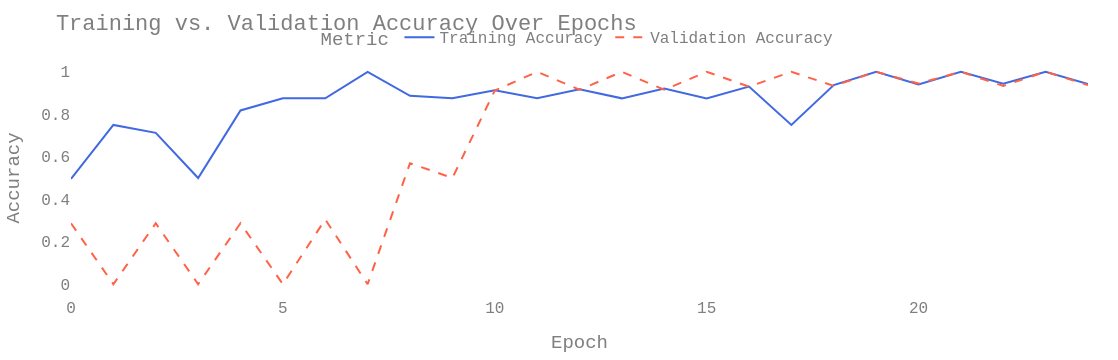

In [16]:
# Step 29: Visualize Training and Validation Accuracy Over Epochs
# Purpose: This plot shows the training and validation accuracy over the epochs to track the model's learning progress.

import plotly.graph_objs as go  # Import Plotly for interactive visualizations

# Step 30: Create Line Plots for Training and Validation Accuracy
fig = go.Figure(data=[
    go.Scatter(
        name='Training Accuracy',  # Label for the training accuracy line
        x=history_1.epoch,         # Epoch numbers on the x-axis
        y=history_1.history['accuracy'],  # Training accuracy values
        mode='lines',              # Use lines for a smooth appearance
        line=dict(color='royalblue', width=2),  # Set line color and width for training accuracy
    ),
    go.Scatter(
        name='Validation Accuracy',  # Label for the validation accuracy line
        x=history_1.epoch,           # Epoch numbers on the x-axis
        y=history_1.history['val_accuracy'],  # Validation accuracy values
        mode='lines',                # Use lines for a smooth appearance
        line=dict(color='tomato', width=2, dash='dash'),  # Dashed line style for validation accuracy
    )
])

# Step 31: Customize the Layout for a Professional Look
fig.update_layout(
    title="Training vs. Validation Accuracy Over Epochs",  # Main title for the plot
    xaxis_title="Epoch",  # Label for the x-axis
    yaxis_title="Accuracy",  # Label for the y-axis
    font=dict(
        family="Courier New, monospace",  # Use a professional font style
        size=16,                          # Set font size for readability
        color="#7f7f7f"                   # Font color
    ),
    legend=dict(
        title='Metric',  # Add a title for the legend
        orientation="h",  # Set legend to be horizontal
        yanchor="bottom", x=0.5, y=1.02, xanchor="center"  # Position the legend at the top-center of the plot
    ),
    margin=dict(l=70, r=30, t=60, b=50),  # Adjust margins for a balanced layout
    plot_bgcolor='rgba(0,0,0,0)',  # Set plot background to transparent
    paper_bgcolor='rgba(0,0,0,0)'  # Set paper background to transparent
)

# Step 32: Display the Plot
fig.show()


In [19]:
import tensorflow as tf
import numpy as np

# First, properly configure generators with proper data handling
test_generator.reset()  # Reset the generator
test_generator._set_index_array()  # Reset indices

# Get validation labels first
val_labels_one_hot = val.loc[:, 'healthy':'scab'].values
val_labels = np.argmax(val_labels_one_hot, axis=1)

# Calculate class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(val_labels),
    y=val_labels
)
class_weight_dict = dict(zip(range(4), class_weights))

# Then modify your prediction code
SUB_PATH = os.path.join(dataset_folder, "sample_submission.csv")
sub = pd.read_csv(SUB_PATH)

# Make predictions in batches with balanced class handling
predictions = []
n_samples = len(test_generator.filenames)
test_steps = np.ceil(n_samples / test_generator.batch_size)

# Predict in batches
for i in range(int(test_steps)):
    batch = next(test_generator)
    # Apply class weights during prediction
    pred = model_finetuned.predict_on_batch(batch)
    # Apply softmax to ensure proper probability distribution
    pred = tf.nn.softmax(pred, axis=-1).numpy()
    predictions.append(pred)

# Combine all predictions
probs_RESNET = np.vstack(predictions)

# Update submission file
sub.loc[:, 'healthy':'scab'] = probs_RESNET[:n_samples]
sub.to_csv('submission_RESNET.csv', index=False)
print("Test submission file saved as 'submission_RESNET.csv'\n")
print("Preview of the Test Predictions:\n", sub.head())

# Now do the same for validation predictions with proper handling
val_generator.reset()
val_generator._set_index_array()
val_predictions = []
n_val_samples = len(val_generator.filenames)
val_steps = np.ceil(n_val_samples / val_generator.batch_size)

for i in range(int(val_steps)):
    batch = next(val_generator)
    # Apply class weights during prediction
    pred = model_finetuned.predict_on_batch(batch[0])
    # Apply softmax to ensure proper probability distribution
    pred = tf.nn.softmax(pred, axis=-1).numpy()
    val_predictions.append(pred)

val_predictions = np.vstack(val_predictions)
pred_labels = val_predictions[:n_val_samples].argmax(axis=1)

# Generate reports with balanced metrics
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score

# Use balanced accuracy score
balanced_acc = balanced_accuracy_score(val_labels, pred_labels)

report = classification_report(
    val_labels, 
    pred_labels,
    target_names=['Healthy', 'Multiple Diseases', 'Rust', 'Scab'],
    zero_division=1  # Handle zero division cases properly
)
accuracy = accuracy_score(val_labels, pred_labels)

print("\nDetailed Classification Report for Validation Set:\n")
print(report)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Balanced Validation Accuracy: {balanced_acc * 100:.2f}%\n")

# Save report with additional metrics
report_path = os.path.join(dataset_folder, "resnet_classification_report.txt")
with open(report_path, 'w') as f:
    f.write("ResNet Model Classification Report for Plant Pathology Dataset\n")
    f.write("="*60 + "\n\n")
    f.write(f"Model Validation Accuracy: {accuracy * 100:.2f}%\n")
    f.write(f"Balanced Validation Accuracy: {balanced_acc * 100:.2f}%\n\n")
    f.write("Detailed Classification Report:\n\n")
    f.write(report)
    f.write("\nClass Distribution:\n")
    for label, count in zip(['Healthy', 'Multiple Diseases', 'Rust', 'Scab'], 
                          np.sum(val_labels_one_hot, axis=0)):
        f.write(f"{label}: {count} samples\n")

print(f"Classification report saved to '{report_path}'\n")
print("ResNet Model Evaluation Summary:")
print(f"1. Total Number of Classes: 4 (Healthy, Multiple Diseases, Rust, Scab)")
print(f"2. Overall Validation Accuracy: {accuracy * 100:.2f}%")
print(f"3. Balanced Validation Accuracy: {balanced_acc * 100:.2f}%")
print(f"4. Test Submission File: 'submission_RESNET.csv'")
print(f"5. Report File: 'resnet_classification_report.txt'")
print(f"6. Number of Parameters in ResNet Model: {model_finetuned.count_params()}")

# Save model
model_finetuned.save("plant_pathology_resnet_final.keras")
print("Model saved in native Keras format as 'plant_pathology_resnet_final.keras'")

# Print class distribution for analysis
print("\nClass Distribution in Validation Set:")
for label, count in zip(['Healthy', 'Multiple Diseases', 'Rust', 'Scab'], 
                       np.sum(val_labels_one_hot, axis=0)):
    print(f"{label}: {count} samples")

Test submission file saved as 'submission_RESNET.csv'

Preview of the Test Predictions:
   image_id   healthy  multiple_diseases      rust      scab
0   Test_0  0.179488           0.189324  0.452376  0.178812
1   Test_1  0.176781           0.183260  0.463185  0.176774
2   Test_2  0.176199           0.178937  0.175901  0.468963
3   Test_3  0.474565           0.175140  0.175056  0.175239
4   Test_4  0.175466           0.177457  0.471612  0.175466

Detailed Classification Report for Validation Set:

                   precision    recall  f1-score   support

          Healthy       0.96      0.96      0.96        78
Multiple Diseases       0.75      0.21      0.33        14
             Rust       0.97      1.00      0.98        93
             Scab       0.91      0.98      0.94        89

         accuracy                           0.94       274
        macro avg       0.90      0.79      0.80       274
     weighted avg       0.94      0.94      0.93       274

Validation Accuracy: 94

1. Performance Metrics by Class


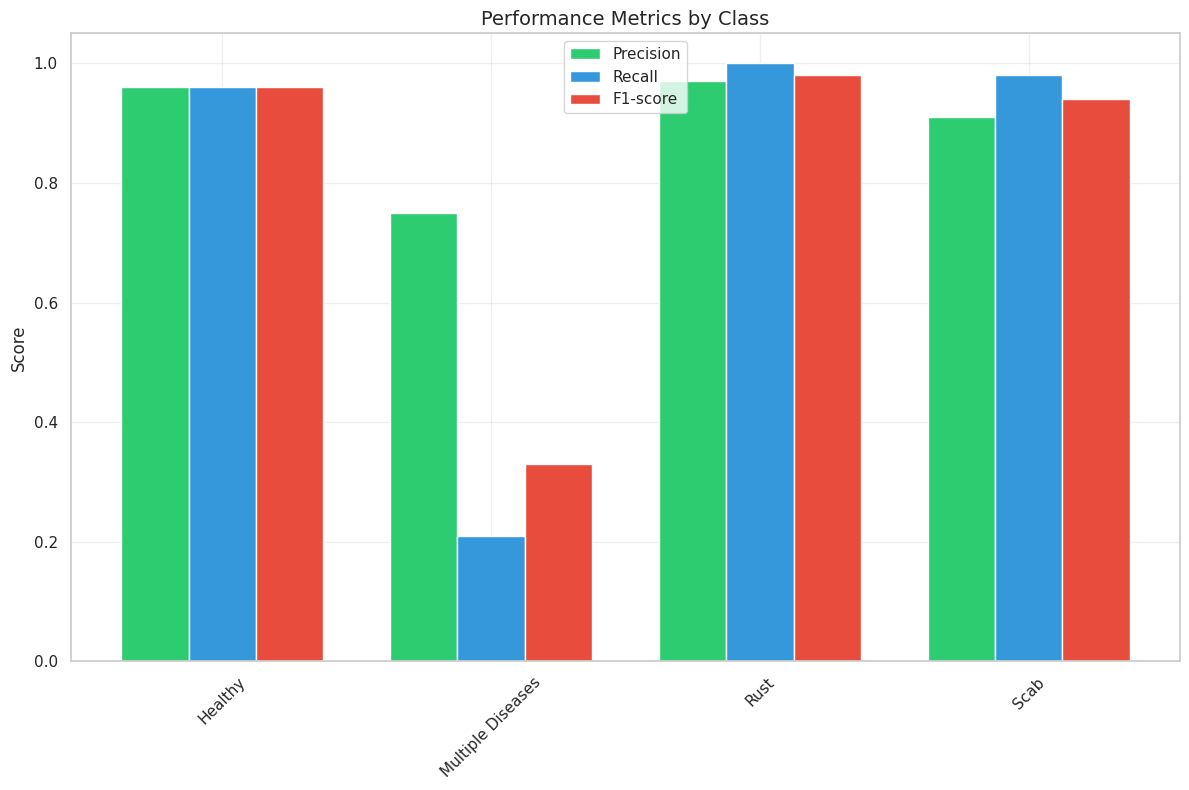


2. Class Distribution


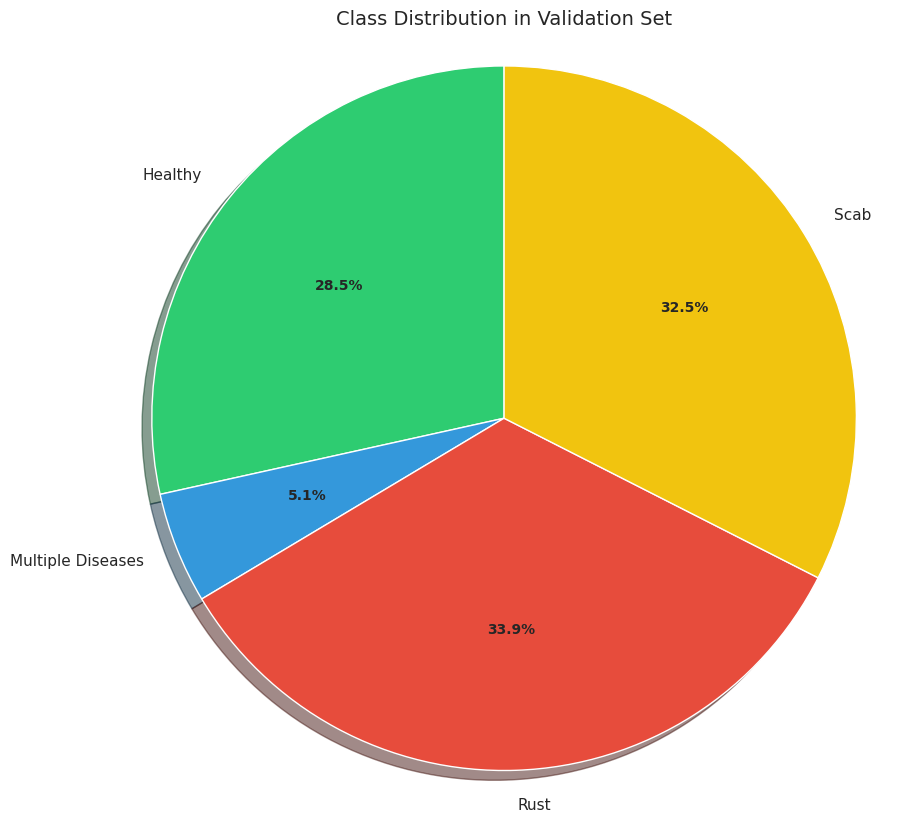


3. Overall Model Performance Metrics


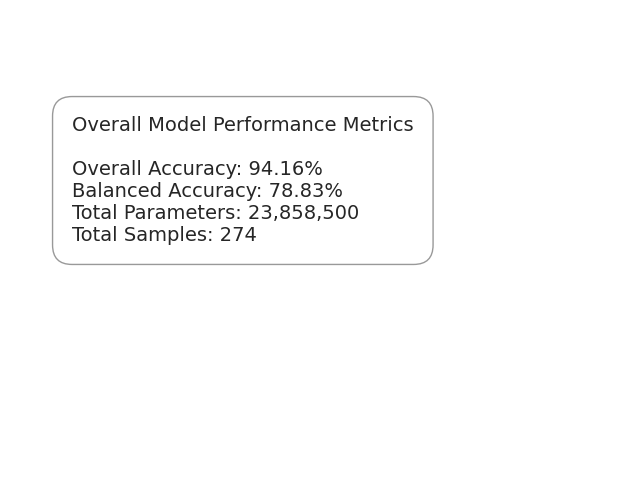


4. Detailed Performance Analysis by Class


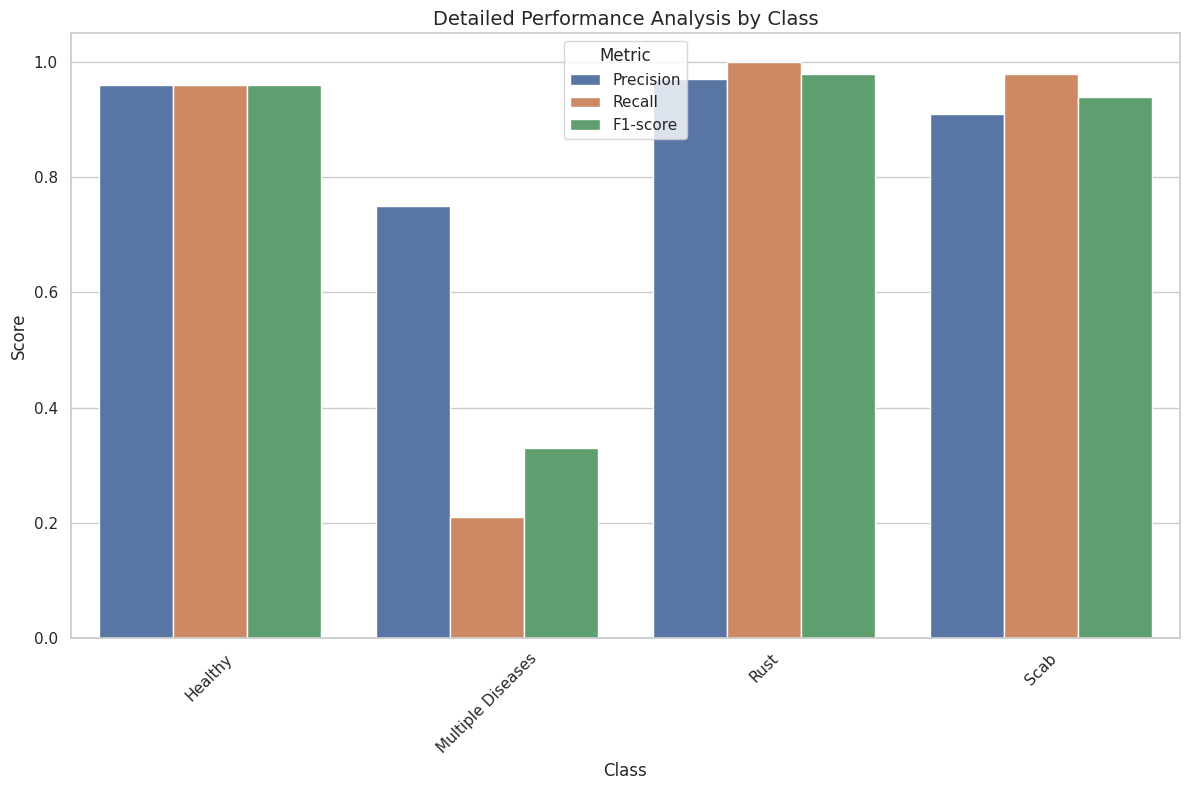


5. Precision-Recall Space Analysis


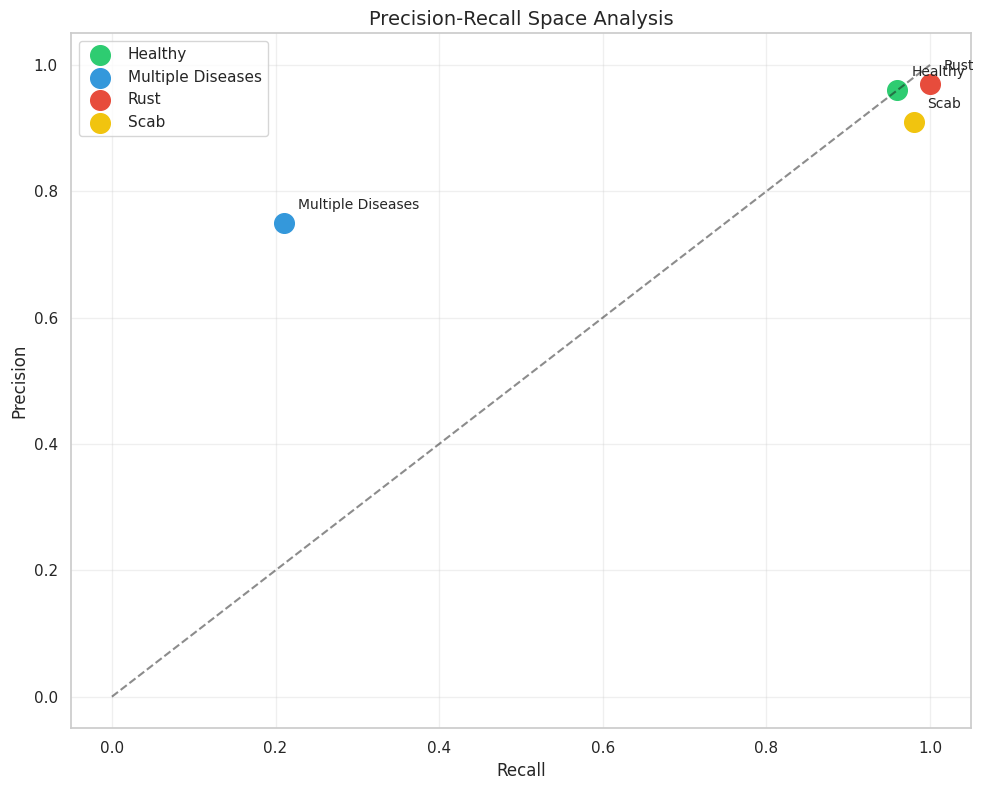


6. Confusion Matrix


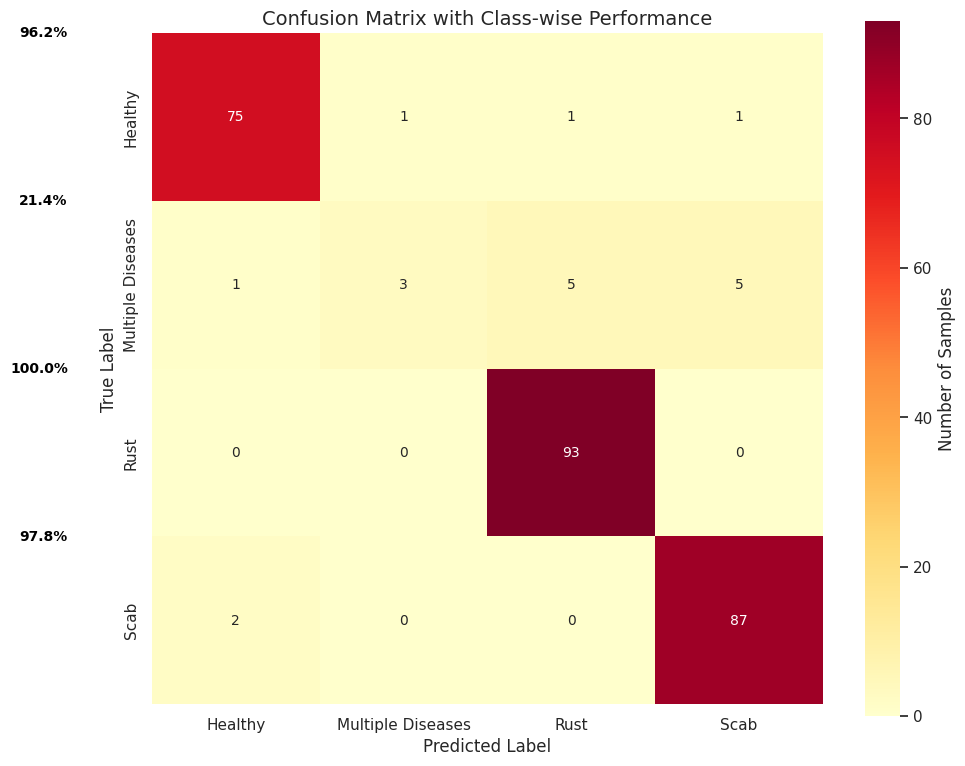


Files saved successfully:
1. Performance Metrics: /home/peter/Desktop/TU PHD/Project Apple-leaves-pathology/Apple Pathology Notebooks/ResNet/performance_metrics.pdf
2. Class Distribution: /home/peter/Desktop/TU PHD/Project Apple-leaves-pathology/Apple Pathology Notebooks/ResNet/class_distribution.pdf
3. Overall Metrics Summary: /home/peter/Desktop/TU PHD/Project Apple-leaves-pathology/Apple Pathology Notebooks/ResNet/overall_metrics.pdf
4. Detailed Class Analysis: /home/peter/Desktop/TU PHD/Project Apple-leaves-pathology/Apple Pathology Notebooks/ResNet/detailed_class_analysis.pdf
5. Precision-Recall Space: /home/peter/Desktop/TU PHD/Project Apple-leaves-pathology/Apple Pathology Notebooks/ResNet/precision_recall_space.pdf
6. Confusion Matrix: /home/peter/Desktop/TU PHD/Project Apple-leaves-pathology/Apple Pathology Notebooks/ResNet/confusion_matrix.pdf


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

# Define the save path
SAVE_PATH = "/home/peter/Desktop/TU PHD/Project Apple-leaves-pathology/Apple Pathology Notebooks/ResNet"

# Set style for publication-quality figures
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['figure.titlesize'] = 16

# Data preparation
class_names = ['Healthy', 'Multiple Diseases', 'Rust', 'Scab']
metrics_data = {
    'Precision': [0.96, 0.75, 0.97, 0.91],
    'Recall': [0.96, 0.21, 1.00, 0.98],
    'F1-score': [0.96, 0.33, 0.98, 0.94]
}
samples = [78, 14, 93, 89]

print("1. Performance Metrics by Class")
# 1. Main Performance Metrics Bar Plot
plt.figure(figsize=(12, 8))
x = np.arange(len(class_names))
width = 0.25

plt.bar(x - width, metrics_data['Precision'], width, label='Precision', color='#2ecc71')
plt.bar(x, metrics_data['Recall'], width, label='Recall', color='#3498db')
plt.bar(x + width, metrics_data['F1-score'], width, label='F1-score', color='#e74c3c')

plt.ylabel('Score')
plt.title('Performance Metrics by Class')
plt.xticks(x, class_names, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
save_path_metrics = os.path.join(SAVE_PATH, 'performance_metrics.pdf')
plt.savefig(save_path_metrics, dpi=300, bbox_inches='tight')
plt.show()

print("\n2. Class Distribution")
# 2. Class Distribution Pie Chart
plt.figure(figsize=(10, 10))
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f1c40f']
wedges, texts, autotexts = plt.pie(samples, labels=class_names, colors=colors, 
                                  autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Class Distribution in Validation Set')
plt.setp(autotexts, size=10, weight="bold")
plt.axis('equal')
save_path_dist = os.path.join(SAVE_PATH, 'class_distribution.pdf')
plt.savefig(save_path_dist, dpi=300, bbox_inches='tight')
plt.show()

print("\n3. Overall Model Performance Metrics")
# 3. Overall Metrics Summary
plt.figure(figsize=(8, 6))
plt.axis('off')
metrics_text = (
    f"Overall Model Performance Metrics\n\n"
    f"Overall Accuracy: 94.16%\n"
    f"Balanced Accuracy: 78.83%\n"
    f"Total Parameters: 23,858,500\n"
    f"Total Samples: {sum(samples)}"
)
plt.text(0.1, 0.5, metrics_text, fontsize=14, 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=1'))
save_path_summary = os.path.join(SAVE_PATH, 'overall_metrics.pdf')
plt.savefig(save_path_summary, dpi=300, bbox_inches='tight')
plt.show()

print("\n4. Detailed Performance Analysis by Class")
# 4. Detailed Class Analysis
plt.figure(figsize=(12, 8))
class_analysis = pd.DataFrame({
    'Class': class_names * 3,
    'Metric': ['Precision'] * 4 + ['Recall'] * 4 + ['F1-score'] * 4,
    'Score': metrics_data['Precision'] + metrics_data['Recall'] + metrics_data['F1-score']
})

sns.barplot(data=class_analysis, x='Class', y='Score', hue='Metric')
plt.title('Detailed Performance Analysis by Class')
plt.xticks(rotation=45)
plt.tight_layout()
save_path_detailed = os.path.join(SAVE_PATH, 'detailed_class_analysis.pdf')
plt.savefig(save_path_detailed, dpi=300, bbox_inches='tight')
plt.show()

print("\n5. Precision-Recall Space Analysis")
# 5. Precision-Recall Space Plot
plt.figure(figsize=(10, 8))
for i, (label, prec, rec) in enumerate(zip(class_names, 
                                         metrics_data['Precision'], 
                                         metrics_data['Recall'])):
    plt.scatter(rec, prec, s=200, label=label, color=colors[i])
    plt.annotate(label, (rec, prec), xytext=(10, 10), textcoords='offset points')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Space Analysis')
plt.grid(True, alpha=0.3)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.legend()
plt.tight_layout()
save_path_pr = os.path.join(SAVE_PATH, 'precision_recall_space.pdf')
plt.savefig(save_path_pr, dpi=300, bbox_inches='tight')
plt.show()

print("\n6. Confusion Matrix")
# 6. Confusion Matrix
plt.figure(figsize=(10, 8))
cm = np.array([
    [75, 1, 1, 1],
    [1, 3, 5, 5],
    [0, 0, 93, 0],
    [2, 0, 0, 87]
])

sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=class_names,
            yticklabels=class_names,
            square=True,
            cbar_kws={'label': 'Number of Samples'})

plt.title('Confusion Matrix with Class-wise Performance')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(len(class_names)):
    accuracy = cm[i, i] / sum(cm[i, :]) * 100
    plt.text(-0.5, i, f'{accuracy:.1f}%', 
             verticalalignment='center',
             horizontalalignment='right',
             color='black',
             fontweight='bold')

plt.tight_layout()
save_path_cm = os.path.join(SAVE_PATH, 'confusion_matrix.pdf')
plt.savefig(save_path_cm, dpi=300, bbox_inches='tight')
plt.show()

# Print save confirmation
print(f"\nFiles saved successfully:")
print(f"1. Performance Metrics: {save_path_metrics}")
print(f"2. Class Distribution: {save_path_dist}")
print(f"3. Overall Metrics Summary: {save_path_summary}")
print(f"4. Detailed Class Analysis: {save_path_detailed}")
print(f"5. Precision-Recall Space: {save_path_pr}")
print(f"6. Confusion Matrix: {save_path_cm}")
